# CDS: Numerical Methods -- Final Assignment

- See lecture notes and documentation on Brightspace for Python and Jupyter basics. If you are stuck, try to google or get in touch via Discord.

- Solutions must be submitted <font color=red>**individually**</font> via the Jupyter Hub until <font color=red>**Monday, April 4th, 23:59**</font>.

- Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

- Remember to document your source codes (docstrings, comments where necessary) and to write it as clear as possible.

- Do not forget to fully annotate all of your plots.

## Submission

1. make sure everything runs as expected
2. **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
3. **run all cells** (in the menubar, select Cell$\rightarrow$Run All)
4. Check all outputs (Out[\*]) for errors and **resolve them if necessary**
5. submit your solutions  **in time (before the deadline)**

## Tight-Binding Propagation Method Module

### Tight-Binding Theory

Solid state theory aims to describe crystalline structures defined by periodic arrangements of atomic positions $\vec{R}_i$ with $i= 1 \dots n$. To model the electronic properties of such a structure, we can use the so-called tight-binding method. Here one assumes that the problem for a single atom described by the Hamiltonian $H_{at}(\vec{r})$ has already been solved, so that the atomic wave functions $\phi_m(\vec{r})$ are known. The Hamiltonian of the crystalline structure is then constructed from these atomic Hamiltonians as follows 

\begin{align*}
    H(\vec{r}) = \sum_{i} H_{at}(\vec{r} - \vec{R}_i) + \Delta V(\vec{r}),
\end{align*}

where $\Delta V(\vec{r})$ describes the changes to the atomic potentials due to the periodic arrangement. Solutions to the time-dependent Schrödinger equation $\psi_n(\vec{r})$ can then be approximated by linear combinations of the atomic orbitals, i.e. 

\begin{align*}
    \psi_m(\vec{r}) = \sum_{i} \, c_{i,m} \, \phi_m(\vec{r}-\vec{R}_i). 
\end{align*}

Thus, our task is to find the coefficients $c_{i,m}$, which are the eigenfunctions of the tight-binding Hamiltonian $H_{tb}$. In the basis of the atomic orbitals $H_{tb}$ is an $n \times n$ matrix which describes the "hopping" of an electron from one atomic position to the other. In this description the electrons are assumed to be tightly bound to the atomic positions, hence the name of the approach. In summary, we have reduced our original problem $H(\vec{r})$, described in a continuous space $\vec{r}$, to a strongly discretized problem $H_{tb}$ in the space of lattice coordinates $\vec{R}_i$.

### Propagation Method
	
While this reduction already helps a lot, full diagonalizations of the tight-binding matrix is still not feasible if we need to describe realistic structures with thousands of atoms. For this case we like to have a method which allows us to study the electronic properties, without the need of fully diagonalizing the tight-binding matrix. The tight-biding propagation method allows for exactly this. By analyzing the propagation of an initial electronic state through the crystalline structure we also have access to the full eigenspectrum of $H_{tb}$, without explicit diagonalization.
	
### Your Goal
    
In the following you will setup the tight-binding Hamiltonian for a one-dimensional chain of atoms and numerically study its properties using exact diagonalization. Then you will compare it to the results obtained using the tight-binding propagation method. You will need some of the algorithms which you have implemented in the weekly assignments before. Additionally, you will need to implement a few new algorithms, which we have discussed in the last lecture. In principle there will be no need to use Numpy or Scipy (except for Numpy's array handling and a few other exceptions). However, if you encounter any problems with your own implementations of specific functionalities, you can use the Numpy and Scipy alternatives. Therefore you should be able to perform all of the following tasks in any case.

Let us start by importing the necessary packages.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg

## Step 1: Crystal Lattice

### Task 1.1 [3 points]

In the following exercises the atomic positions of the 1D crystal lattice will be fixed to $\vec{R}_i = x_i = i a$, with $i = 0 \dots n-1$ and $a$ being the lattice constant.

Write a simple Python function that takes the chain length $n$ as an argument and returns the atomic positions $x_i$. Set $a = 1$ for all the following exercises.

In [2]:
def atomic_positions(n, a=1):
    """
    Creates an array of atomic position in a 1D crystal lattice
    for lattice constant a having default value a = 1.
    
    Args:
        n: number of atoms in the 1D lattice string.
        a: numerical value for the lattice constant.

    Returns:
        A 1D array of atomic positions.
    """
    
    return np.arange(n)*a

## Step 2: Atomic Basis Functions

Our atomic basis functions will be Gaussians of the form
$$
\large
\phi(x, \mu, \sigma) = \frac{1}{\pi^{1/4} \sigma^{1/2}} e^{-\frac{1}{2} \left(\frac{x-\mu}{\sigma}\right)^2},
$$
	where $\mu$ is their localization position and $\sigma$ their broadenings. We also choose to have just one orbital per atom so that we can drop the index $m$ from now on. 
	
### Task 2.1 [4 points]
Implement a Python function which calculates $\phi(x, \mu, \sigma)$ for a whole array of arbitrary $x$, centered at given $\mu$ with a given broadening $\sigma$.

Plot all the atomic basis functions for a chain with $n = 10$ atoms, using $\sigma = 0.25$. I.e. plot $\phi(x, x_i, \sigma)$ vs $x$, for all atomic positions $x_i$ in the chain.

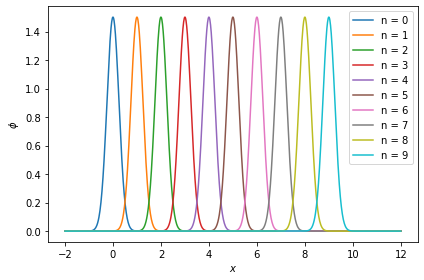

In [3]:
def atomic_basis(x, mu, sigma):
    """
    Calculates the atomic basis functions for the 1D chain of atoms.
    
    Args:
        x:     array of positions to calculate the wavefunction at.
        mu:    atomic position(s) to center Gaussian wavefunction at.
        sigma: broadening constant for Gaussian function(s).

    Returns:
        An array of values for the wavefunction over the positions
        as given by x with shape len(x) by len(mu).
    """
    
    return np.pi**(-1/4)*sigma**(-1/2)*np.exp(-1/2*(np.subtract.outer(x, mu)/sigma)**2)

n = 10
sigma = .25
x = np.linspace(-2, 12, 1000)

plt.figure()
plt.xlabel("$x$")
plt.ylabel("$\phi$")

for mu in atomic_positions(n):
    plt.plot(x, atomic_basis(x, mu, sigma), label="n = " + str(mu))

plt.legend()
plt.tight_layout()
plt.show()

### Task 2.2 [6 points]
Implement a Python function to calculate numerical integrals (using for example the composite trapezoid or Simpson rule). This one should be general enough to calculate integrals $\int_a^b f(x) dx$ for arbitrary functions $f(x)$, as you will need it for other tasks as well.

Implement a simple unit test for your integration function.

In [4]:
def integrate(yk, x):
    """
    Numerically integrates function yk over [x[0], x[-1]] using Simpson's
    composite 3/8 rule over the grid provided by x.
    
    Args:
        yk: function of one numerical argument that returns a numeric
            or an array of function values such that x[i] corresponds to yk[i].
        x:  array of numerics as argument to yk.

    Returns:
        A numeric value for the quadrature of yk over x with error
        of order -h^4/80*(b - a)*f^(4)(xi) for h the maximum time step
        and xi such that the fourth derivative of f is maximal.
    """
    
    # If yk is callable, we use it to determine the function values
    # over array x.
    if callable(yk):
        yk = yk(x)
    
    # The distance h_i = x[i + 1] - x[i] is not necessarily constant. The choice of
    # partitioning of the interval is subject to mathematical considerations I will
    # not go into.
    h = x[1:] - x[:-1]
    
    # TODO: Check implementation of Simpson's 3/8 rule: is there unnecessary overlap?
    integral = 0
    integral += 3/8*(x[1] - x[0])*yk[0]
    integral += 9/8*h[1::3]@yk[1:-1:3]
    integral += 9/8*h[2::3]@yk[2:-1:3]
    integral += 6/8*h[ ::3]@yk[ :-1:3]
    integral += 3/8*(x[-1] - x[-2])*yk[-1]
    return integral

In [5]:
def test_integrate():
    """
    Tests the implementation of Simpson's 3/8 rule in function integrate
    with two test case integrals.
    """
    
    # Test integral 1 of f with F its primitive with integration constant 0
    f = lambda x: x**2
    F = lambda x: x**3/3
    x = np.logspace(0, 3, 1000000)
    assert np.isclose(integrate(f, x), F(x[-1]) - F(x[0]))
    
    # Test integral 2 of f with F its primitive with integration constant 0
    f = lambda x: np.sin(2*x)/(2 + np.cos(2*x))
    F = lambda x: -.5*np.log(np.cos(2*x) + 2)
    x = np.linspace(0, 10, 1000)
    assert np.isclose(integrate(f, x), F(x[-1]) - F(x[0]))
    
test_integrate()

### Task 2.3 [2 points]
Use your Python integration function to check the orthogonality of the Gaussian basis functions by verifying the following condition $$\delta_{ij} = \int_{-\infty}^{+\infty} \phi(x, x_i, \sigma) \, \phi(x, x_j, \sigma) \, dx,$$ where $\delta_{ii} \approx 1$ and $\delta_{ij} \approx 0$ for $\sigma = 0.25$.

In [6]:
n = 10
sigma = .25

positions = atomic_positions(n)
infty = 10000
x = np.linspace(-infty, infty, 1000000)

def ijlabel(i, j):
    """
    Returns a string label describing the relation between two states in words,
    if they are close enough.
    """
    
    if i == j:
        return "   (self)"
    if abs(i - j) == 1:
        return "   (nearest neighbours)"
    # Default:
    return ""

for i in range(n):
    for j in range(n):
        integrand = lambda x: atomic_basis(x, positions[i], sigma)*atomic_basis(x, positions[j], sigma)
        print("delta_{}{} = {:.5f}{}".format(i, j, integrate(integrand, x), ijlabel(i, j)))

delta_00 = 1.00000   (self)
delta_01 = 0.01832   (nearest neighbours)
delta_02 = 0.00000
delta_03 = 0.00000
delta_04 = 0.00000
delta_05 = 0.00000
delta_06 = 0.00000
delta_07 = 0.00000
delta_08 = 0.00000
delta_09 = 0.00000
delta_10 = 0.01832   (nearest neighbours)
delta_11 = 1.00000   (self)
delta_12 = 0.01832   (nearest neighbours)
delta_13 = 0.00000
delta_14 = 0.00000
delta_15 = 0.00000
delta_16 = 0.00000
delta_17 = 0.00000
delta_18 = 0.00000
delta_19 = 0.00000
delta_20 = 0.00000
delta_21 = 0.01832   (nearest neighbours)
delta_22 = 1.00000   (self)
delta_23 = 0.01832   (nearest neighbours)
delta_24 = 0.00000
delta_25 = 0.00000
delta_26 = 0.00000
delta_27 = 0.00000
delta_28 = 0.00000
delta_29 = 0.00000
delta_30 = 0.00000
delta_31 = 0.00000
delta_32 = 0.01832   (nearest neighbours)
delta_33 = 1.00000   (self)
delta_34 = 0.01832   (nearest neighbours)
delta_35 = 0.00000
delta_36 = 0.00000
delta_37 = 0.00000
delta_38 = 0.00000
delta_39 = 0.00000
delta_40 = 0.00000
delta_41 = 0.00000
delta

## Step 3: Tight-Binding Hamiltonian

The tight-binding Hamiltonian for our 1D chain should describe the hopping of an electron from all atomic positions to their nearest left and right neighbours (i.e. no long-range hopping). The resulting matrix representation in the basis of the discrete $x_i$ positions is therefore given as a tri-diagonal $n \times n$ matrix of the form

\begin{align}
    \mathbf{H}_{tb} =
    \left( \begin{array}{cccc}
    0 & t & & 0\\
    t & \ddots & \ddots &  \\
      & \ddots & \ddots &  t \\
    0 &  & t & 0
    \end{array}  \right),
\end{align}

where $t = t_{i,i\pm1}$ is the nearest-neighbour hopping matrix element. A hopping matrix element $t_{i,j}$ is a measure for the probability of an electron to hop from site $i$ to site $j$. They are defined as

\begin{align}
    t_{i,j} = \int_{-\infty}^{+\infty} \phi(x, x_i, \sigma) \, \Delta V(x) \, \phi(x, x_j, \sigma) \, dx,
\end{align}

with the potential fixed to

\begin{align}
    \Delta V(x) = \sum_i \frac{-1}{|x - x_i| + 0.001}.
\end{align}

### Task 3.1 [3 points]
Write a Python function to calculate $t_{i,j}$, using $\sigma = 0.25$. The function should have as input the indices $i$ and $j$, and the chain length $n$. Verify that the long-range hoppings $t_{i,i\pm2}$ and $t_{i,i\pm3}$ are negligible compared to $t_{i,i\pm1}$.

Hint: use your integration function from task 2.2

In [7]:
def hopping(i, j, n, sigma=.25, a=1):
    """
    Calculates hopping matrix elements t_ij for sigma = 0.25 in a 1D
    chain of n atoms at distance a = 1 from eachother.
    
    Args:
        i:     origin site index.
        j:     destination site index.
        n:     number of atoms in the chain.
        sigma: standard deviation to the Gaussian wave functions.
        a:     the lattice constant of the 1D chain of atoms.

    Returns:
        Hopping parameter t_ij.
    """
    
    positions = atomic_positions(n, a)
    
    # This 'infinity' is large enough, as the Gaussians decay quite quickly
    # away from the atomic positions, which we already saw in the overlap
    # above. In fact, 99.7% of all probability mass is under the integral
    # for x radius of 3*sigma from the centers x_i.
    h = 1e-5
    x = np.arange(positions[0] - 10*sigma, positions[-1] - 10*sigma, h)
    
    def V(x):
         ret = np.zeros(x.shape)
         for x_i in positions:
             ret += -1./(np.abs(x - x_i) + 0.001)
         return ret
    # Instead of using a loop, one could vectorize the problem further by calculating all sum
    # terms as elements of a len(x) by len(positions) matrix and then summing along the rows.
    # In testing I found that this was slower than using the loop, so I commented it out.
    # This might be due to the large memory overhead O(len(x)*len(positions)), and the fact that
    # the len(positions) iterations already do vectorized calculations on len(x) >> len(positions)
    # numbers, making the theoretical speed gain only plausible at larger len(positions). 
    #V = lambda x: np.sum( -1/( np.abs(np.subtract.outer(x, positions)) + 0.001 ), axis=1 )
    
    integrand = lambda x: atomic_basis(x, positions[i], sigma)*V(x)*atomic_basis(x, positions[j], sigma)
    return integrate(integrand, x)

In [8]:
n = 10

for i in range(n):
    print("For i =", i, "...")
    for r in range(1, 4):
        if i - r >= 0:
            print("\tt_{{i,i-{}}} = {}".format(r, hopping(i, i - r, n)))
        if i + r < n:
            print("\tt_{{i,i+{}}} = {}".format(r, hopping(i, i + r, n)))
    print()

For i = 0 ...
	t_{i,i+1} = -0.13849173441658025
	t_{i,i+2} = -3.088088057066831e-06
	t_{i,i+3} = -1.8833562200578063e-15

For i = 1 ...
	t_{i,i-1} = -0.13849173441658025
	t_{i,i+1} = -0.14871538221422848
	t_{i,i+2} = -3.1306987950404085e-06
	t_{i,i+3} = -1.945630457066332e-15

For i = 2 ...
	t_{i,i-1} = -0.14871538221422848
	t_{i,i+1} = -0.15363274031153992
	t_{i,i-2} = -3.088088057066831e-06
	t_{i,i+2} = -3.152251440766849e-06
	t_{i,i+3} = -1.9763481552880358e-15

For i = 3 ...
	t_{i,i-1} = -0.15363274031153992
	t_{i,i+1} = -0.1560583006931239
	t_{i,i-2} = -3.1306987950404085e-06
	t_{i,i+2} = -3.1616643825949025e-06
	t_{i,i-3} = -1.8833562200578063e-15
	t_{i,i+3} = -1.9857521228152284e-15

For i = 4 ...
	t_{i,i-1} = -0.1560583006931239
	t_{i,i+1} = -0.15680086580653224
	t_{i,i-2} = -3.1522514407668485e-06
	t_{i,i+2} = -3.1616580341274714e-06
	t_{i,i-3} = -1.945630457066332e-15
	t_{i,i+3} = -1.9763479030784917e-15

For i = 5 ...
	t_{i,i-1} = -0.15680086580653224
	t_{i,i+1} = -0.1560582

### Task 3.2 [3 points]
Implement a diagonalization routine for tri-diagonal matrices which returns all eigenvalues, for example using the $QR$ decomposition (it is fine to use Numpy's $\text{qr()}$). 

Hint: For tri-diagonal matrices with vanishing diagonal elements, the $QR$-decomposition-based diagonalization algorithm gets trapped. To get around this you could, for example, add a diagonal $1$ to your matrix, and later subtract $1$ from each eigenvalue.

In [9]:
def QREig(T, eps=1e-6, k_max=10000):
    """
    Follows the method of the QR decomposition based diagonalization routine
    for tridiagonal matrices. The matrix T is diagonalized, resulting in
    all diagonal elements being an eigenvalue.
    
    Args:
        T:     a tridiagonaliz matrix.
        eps:   the desired accuracy.
        k_max: maximum number of iterations after which to cut off.
    
    Returns:
        A one dimensional array with the eigenvalues of the matrix T.
    """
    
    # A square matrix is assumed.
    assert T.shape[0] == T.shape[1]
    
    # Add identity matrix to prevent trapping.
    T += np.eye(len(T), dtype=T.dtype)
    
    e = eps + 1
    k = 0
    while e > eps and k < k_max:
        k += 1
        Q, R = np.linalg.qr(T)
        T = np.matmul(R,Q)
        e = np.sum(np.abs(np.diag(T, k=1)))
    
    # Subtract 1 before returning to compensate the addition
    # of the identity matrix.
    return np.diag(T) - 1

### Task 3.3 [3 points]
Implement a unit test for your diagonalization routine.

In [10]:
def test_QREig():
    """
    Test the implementation of function QREig using two test
    cases.
    """
    
    # Test case one
    T = np.array([
        [1,4,0,0],
        [3,4,1,0],
        [0,2,3,4],
        [0,0,1,3]
    ])
    # Eigenvalues are roots of λ^4 - 11*λ^3 + 25*λ^2 + 31*λ - 46.
    eigenvalues_of_T = np.array([-1.45350244, 1., 4.65531023, 6.79819221])
    assert np.allclose(np.sort(QREig(T)), eigenvalues_of_T)
    
    # Test case two
    T = np.array([
        [1,4,0,0],
        [3,0,1,0],
        [0,2,0,4],
        [0,0,0,3]
    ])
    eigenvalues_of_T = np.sort(np.linalg.eig(T)[0])
    assert np.allclose(np.sort(QREig(T)), eigenvalues_of_T)

test_QREig()

### Task 3.4 [4 points]
First, write a function that generates your tight-binding Hamiltonian $\mathbf{H}_{tb}$, for a given chain length $n$. Use $t = t_{i,i\pm1}$, as calculated in task 3.1. You can choose any $i$ near the center of the chain for the calculation of $t$, as the chain is (approximately) periodic.

Second, use your diagonalization routine to calculate all the eigenvalues $E_m$, for a variety of $n=10,20,40,80,100$. Sort the resulting $E_m$ and plot them vs. $m$.

In [11]:
def TBHamiltonian(n, sigma=.25, a=1):
    """
    Generates the tight-binding hamiltonian H_tb for given chain length n,
    using the approximation of constant hopping parameter in a periodic
    chain of atoms.
    
    By taking the hopping parameter in the center of the chain, the
    periodic boundary is approximated the best.
    
    Args:
        n:     number of atoms in the chain.
        sigma: standard deviation to the Gaussian wave functions.
        a:     the lattice constant of the 1D chain of atoms.

    Returns:
        Tight-binding hamiltonian H_tb.
    """
    
    i = n//2
    t = hopping(i, i + 1, n, sigma, a)
    H_tb = (np.eye(n, n, -1) + np.eye(n, n, 1))*t
    
    return H_tb

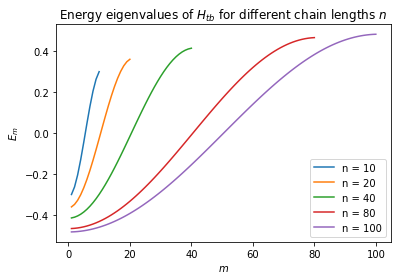

In [12]:
plt.figure()

for n in [10, 20, 40, 80, 100]:
    H_tb = TBHamiltonian(n)
    E_m  = QREig(H_tb)
    plt.plot(np.arange(len(E_m)) + 1, np.sort(E_m), label="n = {}".format(n))

plt.legend()
plt.title("Energy eigenvalues of $H_{{tb}}$ for different chain lengths $n$")
plt.xlabel("$m$")
plt.ylabel("$E_m$")
plt.show()

### Task 3.5 [3 points]
Implement a function to calculate the so-called density-of-states 

\begin{align*}
    \rho(\omega) = \frac{1}{N} \sum_i \delta(\omega - E_i),
\end{align*}

for a variable energy grid $\omega$. Do this by approximating the $\delta$-distribution with a Gaussian. In detail, you can use your atomic orbital function $\delta(\omega - E_i) \approx \phi(\omega, E_i, \sigma_\rho)$. Calculate the normalization factor $N$ such that $\int \rho(\omega) dw = 1$ is fulfilled.

Your function should take as input the energy grid $\omega$, the eigenenergies $E_i$ and the broadening $\sigma_\rho$.

In [13]:
def getDOS_ED(w, Ei, sigma):
    """
    Calculates the density-of-states (DOS) for energy states Ei
    over energy grid w by counting the occupation using a Gaussian
    approximation to the delta function.
    
    Args:
        w:     grid of energies to calculate the DOS over.
        Ei:    array of n eigenenergies for the system.
        sigma: standard deviation to the Gaussian.

    Returns:
        Tight-binding hamiltonian H_tb.
    """
    
    # Luckily, the function is built in such a way it can also
    # handle an array input as its first argument.
    delta = atomic_basis(w, Ei, sigma)
    
    rho = np.sum(delta, axis=1)
    
    # Now normalize rho.
    N = integrate(rho, w)
    rho /= N
    
    return rho

### Task 3.6 [3 points]
Use your density-of-states routine to calculate $\rho(\omega)$ for $n=10,20,40,80,100$ for $\sigma_\rho \approx 0.005$. See below for two examples with $t \approx -0.195$ and $n=10$ and $n=100$.

Hint: if your plots look like they are smoothed out, try decreasing $\sigma_\rho$. If they look like there is a lot of noise, try increasing $\sigma_\rho$.

$n = 10$ | $n = 100$
:-: | :-:
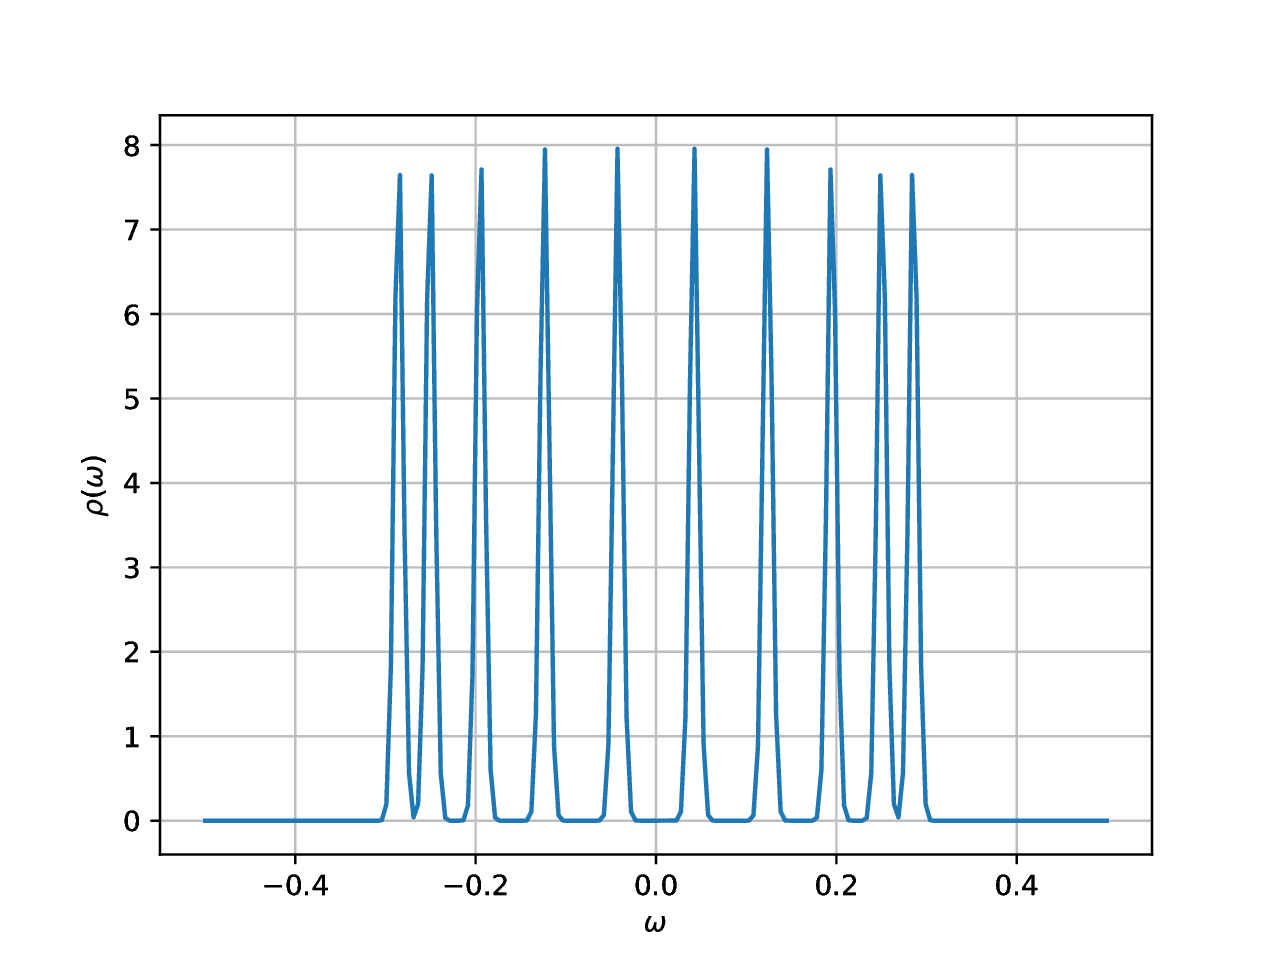 | 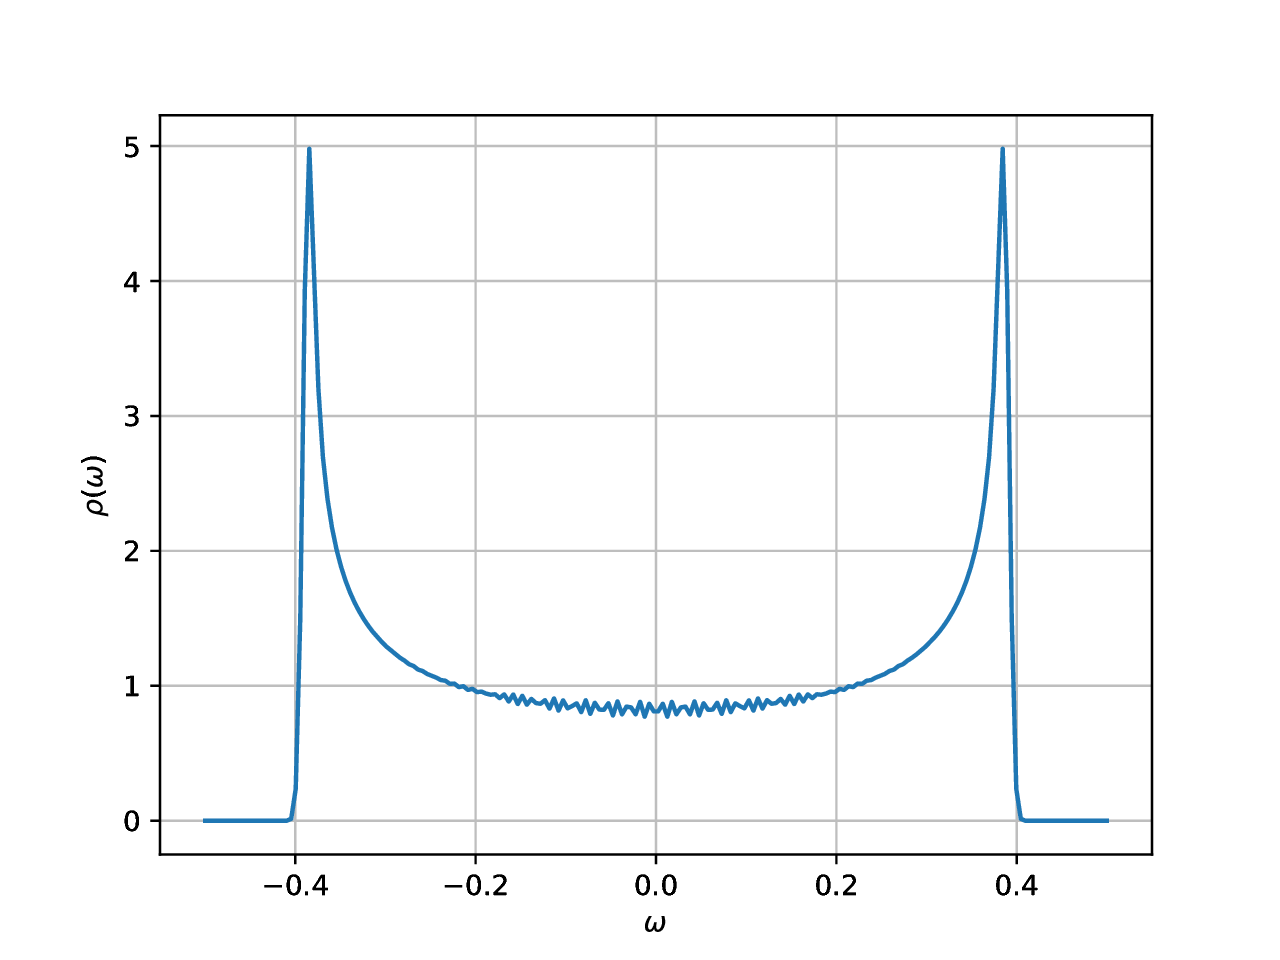

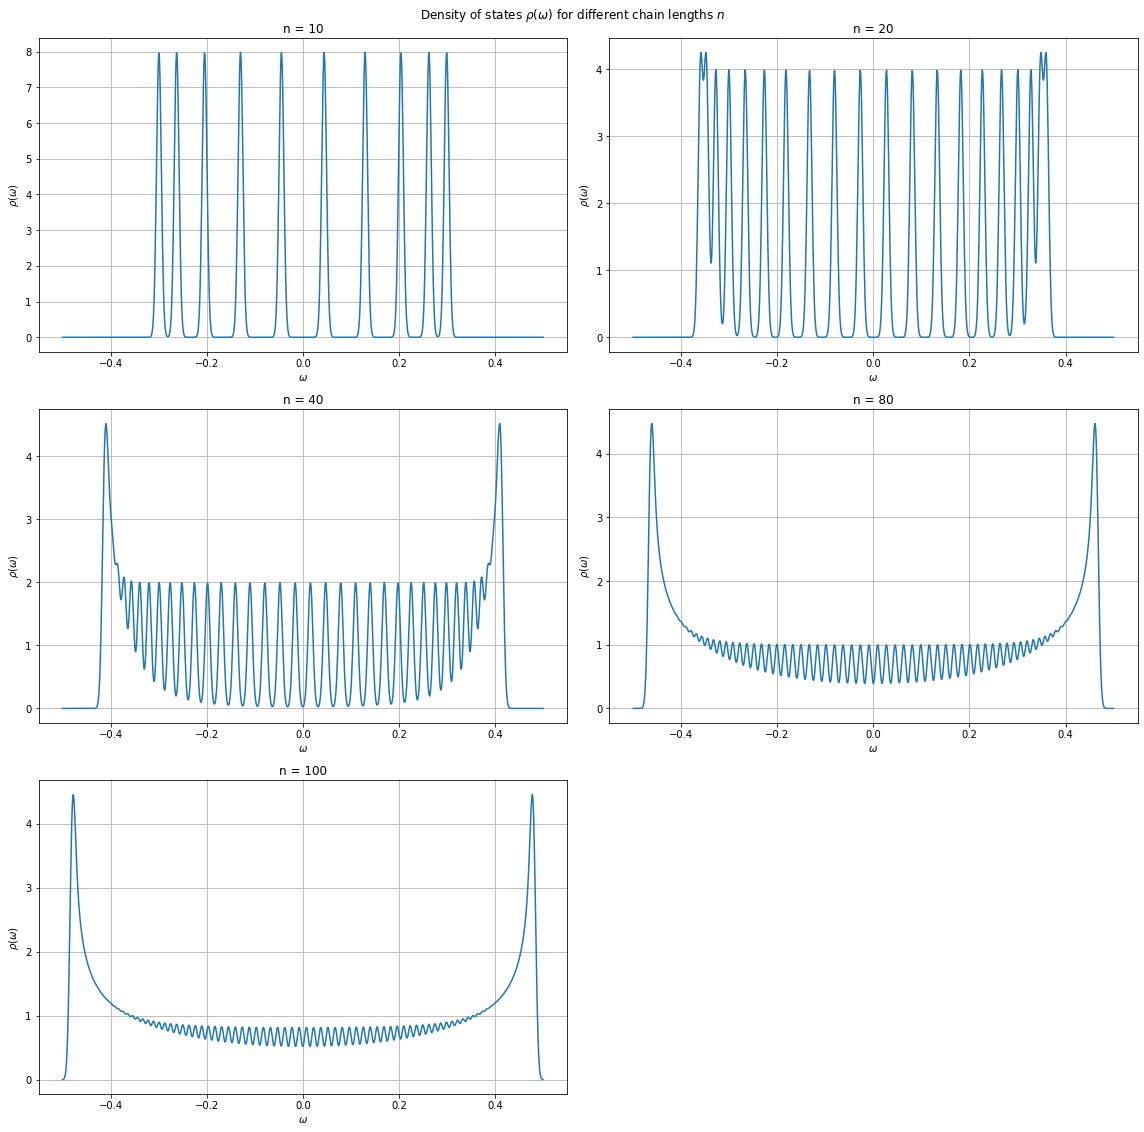

In [14]:
"""
The resulting graphs look similar to the examples,
but there are some notable differences.
* The maximum values seem to coincide.
* The height of the peaks seems to decrease in the example
  for n = 10 whereas that is not observed in my results.
* The oscillations in -0.2 < omega < 0.2 are more
  pronounced in my results. Tuning sigma did not seem
  to help.
"""

sigma = .005
w = np.linspace(-.5, .5, 1000)

fig = plt.figure(figsize=(16,16))

for i, n in enumerate([10, 20, 40, 80, 100]):
    H_tb = TBHamiltonian(n)
    # TODO: Decide whether to implement this + 1 - 1 trick here or in QREig above.
    E_m  = QREig(H_tb + np.eye(n)) - 1
    DOS = getDOS_ED(w, E_m, sigma)
    
    ax = fig.add_subplot(3, 2, i + 1)
    ax.plot(w, DOS, label="n = {}".format(n))
    ax.set_xlabel("$\\omega$")
    ax.set_ylabel("$\\rho(\\omega)$")
    ax.grid()
    ax.set_title("n = {}".format(n))

fig.suptitle("Density of states $\\rho(\\omega)$ for different chain lengths $n$")
fig.tight_layout()
fig.show()

## Step 4: Tight-Binding Propagation Method

Now we turn to the time-dependent Schrödinger equation

\begin{align}
    i\hbar\frac{\partial}{\partial t} \psi(x,t) = H \psi(x,t),
\end{align}

which has the formal solution

\begin{align}
    \psi(x,t) = U(t) \psi(x,t=0),
\end{align}

with 

\begin{align}
    U(t) = e^{-i \hbar H t}
\end{align}

being the time-propagation operator. Within the propagation method we can calculate the so-called local density-of-states

\begin{align}
    \rho_{loc}(\omega) = \frac{1}{2\pi} \int_{-\infty}^{+\infty} \, e^{i\omega t} \, f(t) \ dt,
\end{align}

with respect to an (arbitrary) initial state $\psi(x,t=0)$, where

\begin{align}
    f(t) &= \int_{-\infty}^{+\infty} \, \psi^*(x,t) \, \psi(x,t=0) \, dx \\
         &\approx \int_{-\infty}^{+\infty} \sum_i c_i^*(t) \phi(x,x_i,\sigma) \, \sum_j c_j(0) \phi(x,x_j,\sigma) \, dx \notag \\
         &\approx \sum_i c_i^*(t) c_i(0). \notag
\end{align}

Thus, the time propagation of an initial state towards positive *and* negative times followed by a Fourier transform of $f(t)$ yields the local density-of-states. To obtain the full density-of-states we need to average $\rho_{loc}(\omega)$ as follows

\begin{align}
    \rho(\omega) = \lim_{S \to \infty} \frac{1}{S} \sum_p^S \rho^{(p)}_{loc}(\omega)
\end{align}

over a variety of *random* initial states $p$.

### Task 4.1 [3 points]
Implement a function which calculates the exact time-propagation matrix $U(\tau)$ for a small time-step $\tau$ given the Hamiltonian $H$. For simplicity, set $\hbar = 1$ in the following. 

Hint: Use Scipy's $\text{expm()}$ function.

In [15]:
def getU_exact(tau, H):
    """
    Calculates the time propagation matrix for time-step tau.
    
    Args:
        tau: Time-step numeric to calculate the time-propagation matrix at.
        H:   n by n array representing the hamiltonian matrix.

    Returns:
        The n by n time propagation matrix U(tau).
    """
    
    hbar = 1
    return scipy.linalg.expm(-1j*hbar*H*tau)

### Task 4.2 [3 points]
Implement a function which performs the step-by-step time propagation given an initial state $\vec{c}(0)$, the matrix $U(\tau)$ and the discretized time grid $t_j$. In other words, your function should calculate 

$$\vec{c}(j+1) = U(\tau) \cdot \vec{c}(j)$$ 

for all $j$ of a given discretized time grid $t_j = j \tau$.

In [16]:
def timePropagate(U, c0, t):
    """
    Calculates the time propagation of c over the equidistant time grid t from
    initial state c0 using constant propagation matrix U
    
    Args:
        U:  Time propagation matrix for constant time interval tau.
        c0: Array of length n representing the initial state.
        t:  Array of equidistant time steps such that t[j] = j*tau for constant
            tau.

    Returns:
        The time propagation array c over time grid t of dimension len(t) by n.
    """
    
    # The function assumes that t[j] = j*tau, so we assert that the
    # values are equidistant.
    assert np.allclose(t[1:] - t[:-1], t[1] - t[0])
    # And that indeed t[0] = 0*tau = 0.
    assert np.allclose(t[0], 0)
    
    c = np.zeros(t.shape + c0.shape, dtype=c0.dtype)
    c[0] = c0
    
    for j in range(1, len(t)):
        c[j] = U@c[j - 1]
    
    return c

### Task 4.3 [4 points]
Use both of the above functions to calculate and animate the time propagation of an initial state

$$\psi(x,t=0) = \phi(x, x_{i=n/2}, \sigma) \leftrightarrow \vec{c}(0) = [c_{i=n/2}(0) = 1, c_{i\neq n/2}(0) = 0]$$

for a $n=100$ chain. Discretize your time grid as $t_j=j\tau$ with $j=0 \dots 200$, and $\tau=1.5$. Use again $a = 1$ and $\sigma=0.25$. 

To plot / animate the time propagation you should plot the real-space wave function $\psi(x,t) \approx \sum_i c_i(t) \phi(x, x_i, \sigma)$.

Hint: use your function from task 3.4 to get the Hamiltonian $H$.

For the animation you can use the following draft:
```python
# use matplotlib's animation package
import matplotlib.pylab as plt
import matplotlib
import matplotlib.animation as animation
# set the animation style to "jshtml" (for the use in Jupyter)
matplotlib.rcParams['animation.html'] = 'jshtml'

# create a figure for the animation
fig = plt.figure()
plt.grid(True)
plt.xlim( ... )     # fix x limits
plt.ylim( ... )     # fix y limits

# Create an empty plot object and prevent its showing (we will fill it each frame)
myPlot, = plt.plot([0], [0])
plt.close()

# This function is called each frame to generate the animation (f is the frame number)
def animate(f):                   
    myPlot.set_data( ... )  # update plot

# Show the animation
frames = np.arange(1, np.size(t))  # t is the time grid here
myAnimation = animation.FuncAnimation(fig, animate, frames, interval = 20)
myAnimation
```

In [17]:
n = 100
a = 1
sigma = .25
tau = 1.5
t = np.arange(201)*tau

H = TBHamiltonian(n, sigma)
U = getU_exact(tau, H)
# In general, c0 is complex.
c0 = np.zeros(n, dtype=np.complex128)
c0[n//2] = 1

c = timePropagate(U, c0, t)
xi = atomic_positions(n, a)
x = np.linspace(-1, 101, 150)
# In general, psi is thus also complex.
psi = c@atomic_basis(x, xi, sigma).T



In [ ]:
# use matplotlib's animation package
import matplotlib.pylab as plt
import matplotlib
import matplotlib.animation as animation
# set the animation style to "jshtml" (for the use in Jupyter)
matplotlib.rcParams['animation.html'] = 'jshtml'

# create a figure for the animation
fig = plt.figure()
plt.grid(True)
plt.xlim(-1, 101)     # fix x limits
plt.ylim(-.5, .6)     # fix y limits
plt.xlabel('$x$')
plt.ylabel('$\\psi(t, x)$')

# Create an empty plot object and prevent its showing (we will fill it each frame)
myPlot, = plt.plot([0], [0])
plt.close()

# This function is called each frame to generate the animation (f is the frame number)
def animate(f):                   
    myPlot.set_data(x, np.real(psi[f]))  # update plot

# Show the animation
frames = np.arange(1, np.size(t))  # t is the time grid here
myAnimation = animation.FuncAnimation(fig, animate, frames, interval = 20)
myAnimation

### Task 4.4 [3 points]
Implement a function which calculates the Crank-Nicolson time-propagation matrix 

\begin{align*}
    U_{CN}(\tau) = (I - i \tau H / 2)\cdot(I + i \tau H / 2)^{-1}.
\end{align*}

Here, $I$ is the diagonal identity matrix. Use Numpy's $\text{inv()}$ function to invert the needed expression.

In [19]:
def getU_CN(tau, H):
    """
    Calculates the time-propagation matrix for time-step tau using
    the Crank-Nicolson algorithm.
    
    Args:
        tau: time-step numeric to calculate the time-propagation matrix at
        H:   n by n array representing the hamiltonian matrix

    Returns:
        The time-propagation matrix U(tau).
    """
    
    n = len(H)
    
    return (np.eye(n) - 1j*tau*H/2)@np.linalg.inv(np.eye(n) + 1j*tau*H/2)

### Task 4.5 [5 points]
Implement a function which calculates the time-propagation matrix using the Trotter-Suzuki decomposition 

\begin{align*}
    U_{TZ}(\tau) = e^{-i\tau H_1} \cdot e^{-i \tau H_2}.
\end{align*}

In this approach you choose a decomposition of the tight-binding Hamiltonian $H = H_1 + H_2$, which allows you to analytically diagonalize $H_1$ and $H_2$ (see last lecture). From this analytic diagonalization you will be able to calculate the matrix exponentials $e^{-i\tau H_1}$ and $e^{-i \tau H_2}$.

Write your definition of the 2x2 blocks in $e^{-i\tau H_1}$ and $e^{-i \tau H_2}$ in the Markdown cell below. (Double click on "YOUR ANSWER HERE" to open the cell, and ctrl+enter to compile.) 

In the Trotter-Suzuki decomposition, we seek diagonal block matrix forms for $\mathbf{H_1}$ and $\mathbf{H_2}$ such that their sum equals the original matrix $\mathbf{H}$. The exponential is than done for each block instead of the whole matrix, which is a lot less complicated. Afterwards the result is combined such that
$$
e^{-i\tau\mathbf{H}} = e^{-i \tau\left( \mathbf{H_1} + \mathbf{H_2} \right)} \approx e^{-i\tau\mathbf{H_1}} \cdot e^{-i\tau\mathbf{H_2}}.
$$

Here are the forms for the matrices. For $\mathbf{H}$ an $n \times n$ matrix, the form for $n$ odd is written down below. For $n$ even, the last row and column for both matrices can be omitted to see the shape.

$$
\mathbf{H_1} =
\begin{pmatrix}
0 & t &   &   &        &   &   &  \\
t & 0 &   &   &        &   &   &  \\
  &   & 0 & t &        &   &   &  \\
  &   & t & 0 &        &   &   &  \\
  &   &   &   & \ddots &   &   &  \\
  &   &   &   &        & 0 & t &  \\
  &   &   &   &        & t & 0 &  \\
  &   &   &   &        &   &   & 0
\end{pmatrix}
\qquad
\mathbf{H_2} =
\begin{pmatrix}
0 &   &   &   &   &        &   &  \\
  & 0 & t &   &   &        &   &  \\
  & t & 0 &   &   &        &   &  \\
  &   &   & 0 & t &        &   &  \\
  &   &   & t & 0 &        &   &  \\
  &   &   &   &   & \ddots &   &  \\
  &   &   &   &   &        & 0 & t\\
  &   &   &   &   &        & t & 0
\end{pmatrix}
$$

For the exponents, we find the following for $n$ odd, again with the remark that the result for $n$ even can be reached by omitting the last row and column for both matrices and calculating the exponents for them.
\begin{align}
\exp{(-i\tau\mathbf{H_1})} &=
\begin{pmatrix}
\exp{\begin{pmatrix}0 & -i\tau{}t \\ -i\tau{}t & 0\end{pmatrix}} & & & &\\
 & \exp{\begin{pmatrix}0 & -i\tau{}t \\ -i\tau{}t & 0\end{pmatrix}} & & &\\
 & & \ddots & &\\
 & & & \exp{\begin{pmatrix}0 & -i\tau{}t \\ -i\tau{}t & 0\end{pmatrix}} &\\
 & & & & \exp{0}
\end{pmatrix}
\\
\exp{(-i\tau\mathbf{H_2})} &=
\begin{pmatrix}
\exp{0} & & & &\\
 & \exp{\begin{pmatrix}0 & -i\tau{}t \\ -i\tau{}t & 0\end{pmatrix}} & & &\\
 & & \exp{\begin{pmatrix}0 & -i\tau{}t \\ -i\tau{}t & 0\end{pmatrix}} & &\\
 & & & \ddots &\\
 & & & & \exp{\begin{pmatrix}0 & -i\tau{}t \\ -i\tau{}t & 0\end{pmatrix}}\\
 & & & &
\end{pmatrix}
\end{align}

As $\exp{0} = 1$, we just calculate
$$
\exp{\begin{pmatrix}0 & -i\tau{}t \\ -i\tau{}t & 0\end{pmatrix}}
= \begin{pmatrix}\cos{\tau{}t} & -i\sin{\tau{}t} \\ -i\sin{\tau{}t} & \cos{\tau{}t}\end{pmatrix}.
$$


In [20]:
def getU_TZ(tau, H):
    """
    Calculates the time-propagation matrix for time-step tau using
    the Trotter-Suzuki algorithm for a known shape of the hamiltonian
    
    Args:
        tau: time-step numeric to calculate the time-propagation matrix at
        H:   n by n array representing the hamiltonian matrix

    Returns:
        The time-propagation matrix U(tau).
    
    Note:
        Only the size of H is taken into account, as the decomposition is
        pre-defined.
    """
    
    # We assume that H is n by n in the form with constant hopping parameter
    # t on the upper and lower diagonal, and the rest zero.
    n = len(H)
    assert len(H[0] == n)
    
    t = H[0][1]
    H_tb = (np.eye(n, n, -1) + np.eye(n, n, 1))*t
    assert np.allclose(H, H_tb)
    
    
    # First we calculate the exponent of the block.
    exp_block = np.array([
        [    np.cos(tau*t),    -1j*np.sin(tau*t)],
        [-1j*np.sin(tau*t),        np.cos(tau*t)]
    ])
    
    # Now we use the block to calculate the exponent of matrices
    # H_1 and H_2.
    
    # If n is even.
    if n % 2 == 0:
        num = n//2
        exp_H_1 = np.kron(np.eye(num, dtype=int), exp_block)
        
        num = n//2 - 1
        exp_H_2 = np.block([
            [1,                    np.zeros((1, num*2)),                       0                   ],
            [np.zeros((num*2, 1)), np.kron(np.eye(num, dtype=int), exp_block), np.zeros((num*2, 1))],
            [0,                    np.zeros((1, num*2)),                       1                   ]
        ])
    
    # If n is odd.
    else:
        num = n//2
        exp_H_1 = np.block([
            [np.kron(np.eye(num, dtype=int), exp_block), np.zeros((num*2, 1))],
            [np.zeros((1, num*2)),                       1                   ]
        ])

        num = n//2
        exp_H_2 = np.block([
            [1,                    np.zeros((1, num*2))                      ],
            [np.zeros((num*2, 1)), np.kron(np.eye(num, dtype=int), exp_block)]
        ])

    U_TZ = exp_H_1@exp_H_2
    return U_TZ

In [21]:
# TODO: Delete this cell!
n = 10
sigma = .25
tau = 1.5
H = TBHamiltonian(n, sigma)
%timeit U = getU_TZ(tau, H)
%timeit U = getU_exact(tau, H)
%timeit U = getU_CN(tau, H)

exp_block = np.array([
        [    np.cos(tau*t),    -1j*np.sin(tau*t)],
        [-1j*np.sin(tau*t),        np.cos(tau*t)]
    ])
exp_block.shape

158 µs ± 268 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
256 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
45.2 µs ± 84.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


(2, 2, 201)

### Task 4.6 [3 points]
In your implementation of $U_{TZ}(\tau)$ you analytically evaluate the matrix exponentials $e^{-i\tau H_1}$ and $e^{-i \tau H_2}$. Test your implementation by comparing your results for these matrix exponentials to those obtained using Scipy's $\text{expm()}$ function.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Yann printed
#Biggest differences of U1 with Scipy:
#Real: 1e-16 
#Imag: 2.77e-17
#    
# and difference with U_exact in the order of 1e-1 or 1e-2.

### Task 4.7 [6 points]
In the next task you will need a Fourier transform to calculate the local density-of-states. Therefore you will need to implement a function that returns the Fourier transform $f(\omega)$ of a given function $f(t)$ defined on a time grid $t$, for a given energy grid $\omega$. I.e. it should calculate:

\begin{align}
    f(\omega) = \frac{1}{2\pi} \int_{-\infty}^{+\infty} \, e^{i\omega t} \, f(t) \ dt.
\end{align}

Hint: use your integration function from task 2.2.

Then implement a unit test for your function.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Implement your unit test here ...

# YOUR CODE HERE
raise NotImplementedError()

### Task 4.8 [3 points]
Calculate the local density-of-states $\rho_{loc}(\omega)$ from the Fourier transform of $f(t)$ using all three time propagation methods: $U(\tau)$, $U_{CN}(\tau)$ and $U_{TZ}(\tau)$.

Start from $\psi(x,t=0) = \phi(x, x_{i=0}, \sigma)$ and $\psi(x,t=0) = \phi(x, x_{i=n/2}, \sigma)$, using a $n=100$ chain. Discretize your integration time grid as $t_j=j\tau$, with $j=-150 \dots 150$ and $\tau=1.5$. Use again $a = 1$ and $\sigma=0.25$.

Be careful: for the Fourier transform you will need positive *and* negative time steps! Thus you will need to do two time propagations: one using $U(\tau)$ towards positive times and one using $U(-\tau)$ towards negative times, both starting from $\psi(x,t=0)$.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Do your own testing here ...

# YOUR CODE HERE
raise NotImplementedError()

# Yann had a plot for Tau = 1.5
# DOS: looking like a hill ("like a dome with a peak around zero energy 0")
# for CN, TS and the exact one
# a plot of f(t)
# a plot of local DOS
# in the title he mentiones the inital values.

### Task 4.9 [6 points]
Use the Trotter-Suzuki decomposition to calculate the full density-of-states by averaging over about $100$ local density-of-states you obtained from the time propagation of $100$ random initial states $\vec{c}(0)$. To this end, you will need to make sure that each $\vec{c}(0)$ is (a) normalized and (b) can have positive *and* negative elements. 

Compare this approximation to the total density-of-states to the exact one from task 3.6, which you obtained directly from the eigenvalues.

Hint: don't expect the results to be the exact same. Check for the location of the peaks, and whether they have a similar order of magnitude.

Hint: if you did not get the Trotter-Suzuki decomposition to work, you can instead use the exact or the Crank-Nicolson time-propagation matrix.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Yann says the initial states do need to be negative, too.

In [ ]:
# Do your plotting here ...

# YOUR CODE HERE
raise NotImplementedError()

# Yann plotted the exact diagonalisation and the TS propagation results
# he had two plots, one peaky, one with peaks on the edges (looking a little
# like my 1f/2f results in my bachelor internship hmmpfff)